In [1]:
%load_ext autoreload
%autoreload 2


In [21]:
import networkx as nx
import numpy as np
import cvxpy as cp
import copy
from tqdm import tqdm
from pathlib import Path

from src.load_data import (
    read_metadata_networks_tntp,
    read_graph_transport_networks_tntp,
    read_traffic_mat_transport_networks_tntp,
)

from src.models import SDModel, BeckmannModel, TwostageModel
from src.algs import subgd, ustm, frank_wolfe, cyclic, N_conjugate_frank_wolfe 
from src.cvxpy_solvers import get_max_traffic_mat_mul
from src.commons import Correspondences
from src.admm_stuff import AdmmOracle, combined_salim, combined_salim_with_cheb

import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter


plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

%matplotlib inline

In [16]:
networks_path = Path("./TransportationNetworks")

# folder = "SiouxFalls"
# net_name = "SiouxFalls_net"
# traffic_mat_name = "SiouxFalls_trips"

# folder = "Chicago-Sketch"
# net_name = "ChicagoSketch_net"
# traffic_mat_name = "ChicagoSketch_trips"

folder = "Anaheim"
net_name = "Anaheim_net"
traffic_mat_name = "Anaheim_trips"

# folder = "Barcelona"
# net_name = "Barcelona_net"
# traffic_mat_name = "Barcelona_trips"


net_file = networks_path / folder / f"{net_name}.tntp"
traffic_mat_file = networks_path / folder / f"{traffic_mat_name}.tntp"
graph, metadata = read_graph_transport_networks_tntp(net_file)
correspondences = read_traffic_mat_transport_networks_tntp(traffic_mat_file, metadata)
n = graph.number_of_nodes()

print(f"{graph.number_of_edges()=}, {graph.number_of_nodes()=}")

metadata["can_pass_through_zones"]=False
graph.number_of_edges()=914, graph.number_of_nodes()=454


In [ ]:
# # This cell is to add some people to replace zeros in traffic maxtrix but not making flow bigger

# tm = correspondences.traffic_mat
# print(tm.sum())
# tm[tm == 0] = 1
# tm[tm > 10] = tm[tm > 10] * 0.952
# tm.sum()

In [17]:
beckmann_model = BeckmannModel(graph, copy.deepcopy(correspondences))

# Twostage

In [18]:
traffic_mat = correspondences.traffic_mat.copy()
departures, arrivals = traffic_mat.sum(axis=1), traffic_mat.sum(axis=0)
l, w = departures, arrivals
twostage_beckmann_model = TwostageModel(beckmann_model, departures=departures, arrivals=arrivals, gamma=0.1)
admm_oracle = AdmmOracle(twostage_beckmann_model.traffic_model, twostage_beckmann_model.gamma, l, w)

In [38]:
# exact solution via cyclic (if it converges better than salim)
output = cyclic(
    model=twostage_beckmann_model,
    traffic_assigment_eps_abs=10,  # experiment["almost_exact"]["ta_eps_abs"],
    traffic_assigment_max_iter=100,  # experiment["almost_exact"]["max_iter"],
    max_iter=10,  # experiment["meta"]["cyclic_iters"],
    stop_by_crit=False,
)

times_e_best, flows_e_best, corrs_best, logs, optimal = output
times, dgaps = logs[2], logs[0]
# experiment["almost_exact"]["times"] = times
# experiment["almost_exact"]["dgaps"] = dgaps

100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


In [ ]:
# times, dgaps = experiment["almost_exact"]["times"], experiment["almost_exact"]["dgaps"]
ax = plt.figure(figsize=(6, 4)).add_subplot(1, 1, 1)
ax.plot(times, dgaps, label=f"gap")
ax.scatter(times, dgaps)

ax.minorticks_on(), ax.set_yscale("log"), ax.set_ylabel("dgap"), ax.set_xlabel("time, s")
minor_locator = LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=12)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(which="major", linestyle="-", linewidth="0.5", alpha=0.5)
ax.grid(which="minor", linestyle=":", linewidth="0.5", alpha=1)
_ = ax.legend(), plt.show()

In [19]:
# Power method for lam1
oracle = admm_oracle
hf = np.random.random((oracle.n_edges, l.size))
hd = np.random.random((l.size, l.size))
h = np.vstack((hd, hf))


def MTM(h):
    hd, hf = h[: l.size, :], h[l.size :, :]
    vf = oracle.ATmul(oracle.Amul(hf)) + oracle.ATmul(oracle.Bmul(hd))
    vd = oracle.BTmul(oracle.Amul(hf)) + oracle.BTmul(oracle.Bmul(hd)) + oracle.KTmul(oracle.Kmul(hd))
    return np.vstack((vd, vf))


for i in range(10):
    h /= np.linalg.norm(h)
    h = MTM(h)
    lmax = np.linalg.norm(h)
    print("lmax", lmax, lmax / l.size)


def MT(yAB, yK):
    vf = oracle.ATmul(yAB)
    vd = oracle.BTmul(yAB) + oracle.KTmul(yK)
    return np.vstack((vd, vf))

lmax 19.28660494402794 0.5075422353691563
lmax 114.66849136333543 3.0175918779825115
lmax 115.46054083342752 3.038435285090198
lmax 115.50593783544467 3.0396299430380176
lmax 115.52334117791973 3.04008792573473
lmax 115.53107527152059 3.0402914545137
lmax 115.53457355004042 3.040383514474748
lmax 115.53616210809557 3.0404253186340937
lmax 115.53688416415235 3.0404443201092723
lmax 115.53721244664987 3.0404529591223652


  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:14<00:00, 206.37it/s]


lmin 0.07903408016706237 0.0020798442149226938


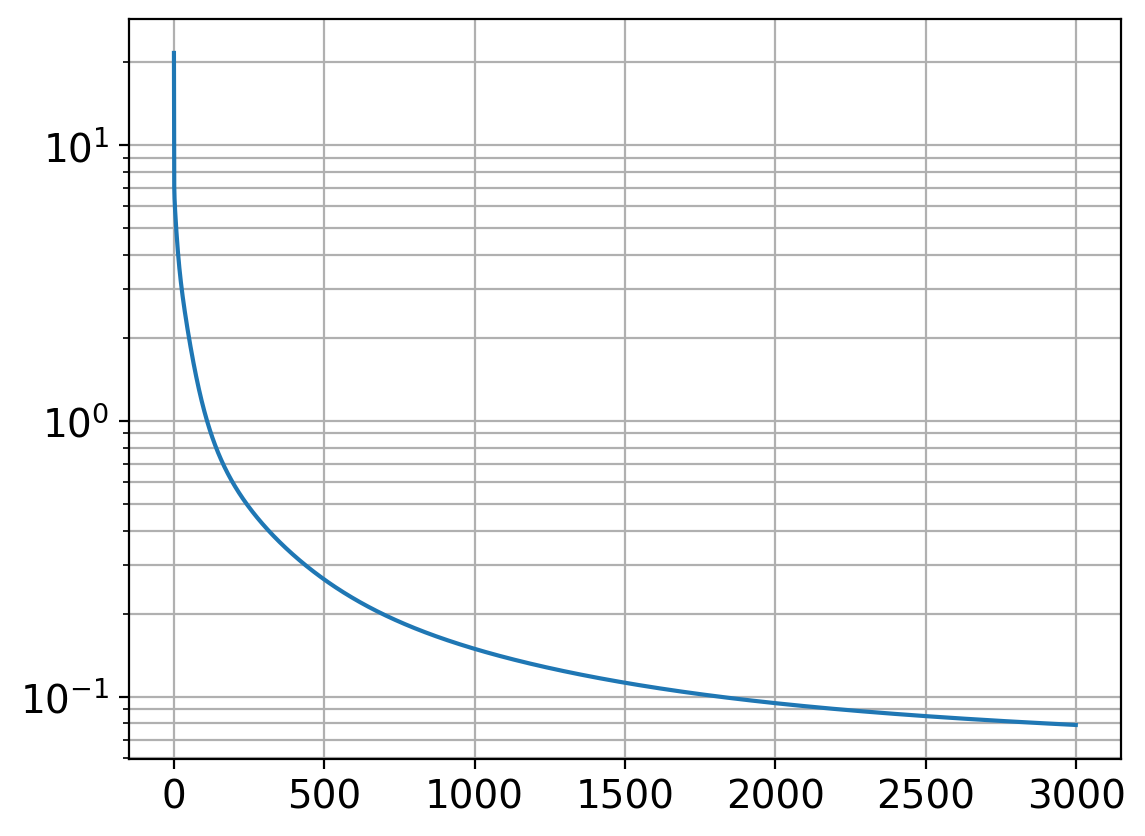

In [20]:
# in Im M^T = (Ker M)^\bot
h = MT(np.random.random(oracle.Amul(hf).shape), np.random.random(oracle.Kmul(hd).shape))
lmins = []
for i in tqdm(range(3000)):
    h /= np.linalg.norm(h)
    h = lmax * h - MTM(h)
    lmin = lmax - np.linalg.norm(h)
    lmins.append(lmin)

print("lmin", lmin, lmin / l.size)

plt.plot(lmins)
plt.grid(which="both")
plt.yscale("log")

In [8]:
# for Sioux-Falls
comment = "3FW in cyclic"
ta_epss = list(10.0 ** np.arange(2, -1, -1))
# agd_kwargs = dict(eps_abs=1e-4, iters=1000, M0=10)
# salim_kwargs = dict(eps_abs=1e-5, iters=1000, mu=0.01, L=1)
experiment = {
    "meta": {
        "network": folder,
        "description": comment,
    },
    #        "almost_exact" : {"max_iter": 10_000, "ta_eps_abs": 1e-2},
    "cyclic_big_iters": 15,
    "cyclic_ta_iters": 10_000,
    "ta_epss": ta_epss,
    "salim_kwargs": dict(mu=1e-4, L=1, lam2=l.size, lam1=3 * l.size),
    "salim_iters": 2000,
    "salim_exact_iters": 5000,
    "data": {
        "dgapss": None,
        "timess": None,
        "distss": None,
        "salim_exact_cons": None,
        "salim_exact_opt": None,
        "salim_times": None,
        "salim_dists": None,
    },
}
data = experiment["data"]

In [9]:
output = combined_salim(admm_oracle, **experiment["salim_kwargs"],
                        iters=experiment["salim_exact_iters"],
                        plot_convergence=False)
corrs_best, flows_best, yK_s, yAB_s, dists_s, times_s, pri_res, opt = output
flows_e_best = flows_best.sum(axis=1)

data["salim_exact_times"], data["salim_exact_cons"], data["salim_exact_opt"] = times_s, pri_res, opt

100%|██████████| 5000/5000 [00:00<00:00, 6872.42it/s]

Lmax= 3.324583346408148
mumin= 0.0006031075675404351
2.1140195103274705e-07 4.130457599775185e-06 1.3037149007096181e-08
salim 4999



/Users/michael/Documents/Transportation/mmo_tm/src/admm_stuff.py:384: RuntimeWarning: Salim reached iter limit
  warnings.warn(f"Salim reached iter limit", category=RuntimeWarning)


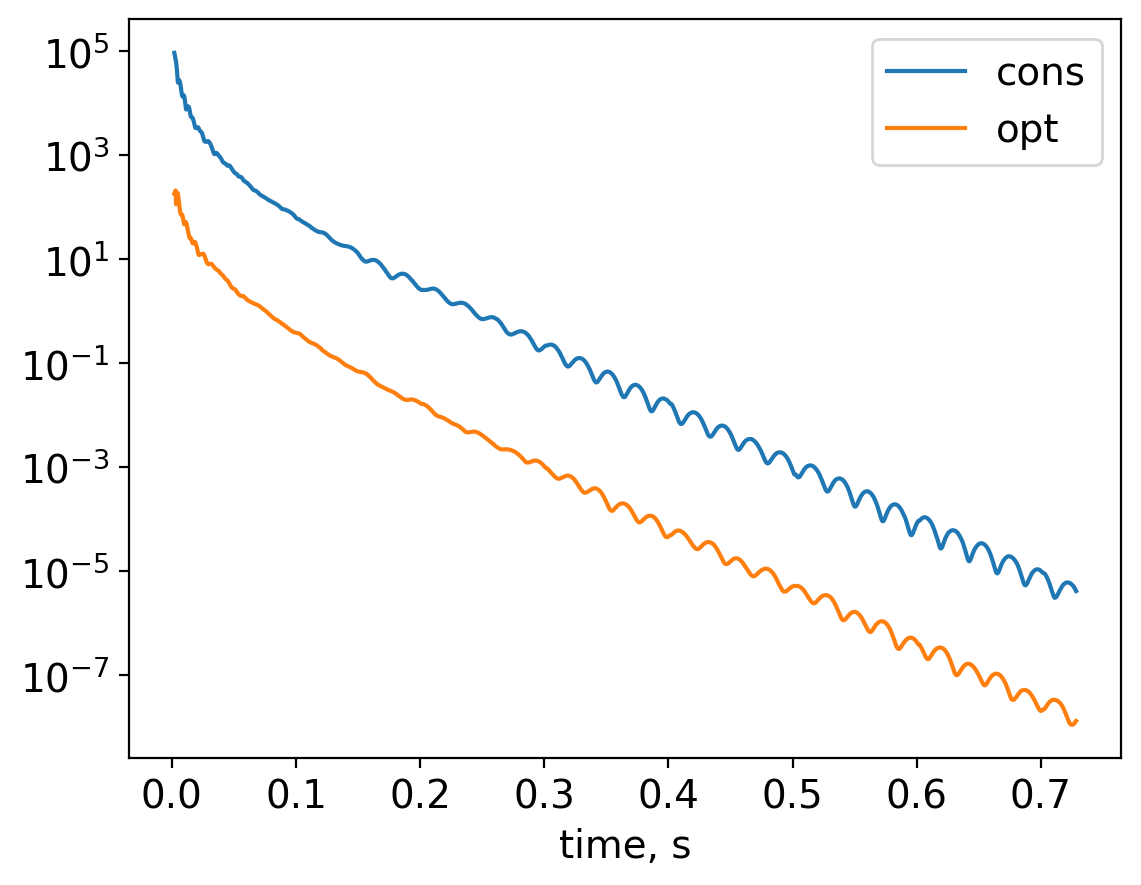

In [10]:
plt.plot(data["salim_exact_times"], data["salim_exact_cons"], label="cons")
plt.plot(data["salim_exact_times"], data["salim_exact_opt"], label="opt")
plt.legend()
plt.xlabel("time, s")
plt.yscale("log")

In [11]:
output = combined_salim(admm_oracle, **experiment["salim_kwargs"], iters=experiment["salim_iters"],
               solution_corrs=corrs_best,
               solution_flows=flows_e_best,
               )
corrs_salim, flows_salim, yK_s, yAB_s, dists_s, times_s, pri_res, opt = output

data["salim_times"], data["salim_dists"] = times_s, dists_s

100%|██████████| 2000/2000 [00:00<00:00, 6536.18it/s]

Lmax= 3.324583346408148
mumin= 0.0006237944271465643
0.014840888964733132 0.19212639125561476 0.0011478223771013254
salim 1999


(<matplotlib.legend.Legend at 0x177bd1cd0>, None)

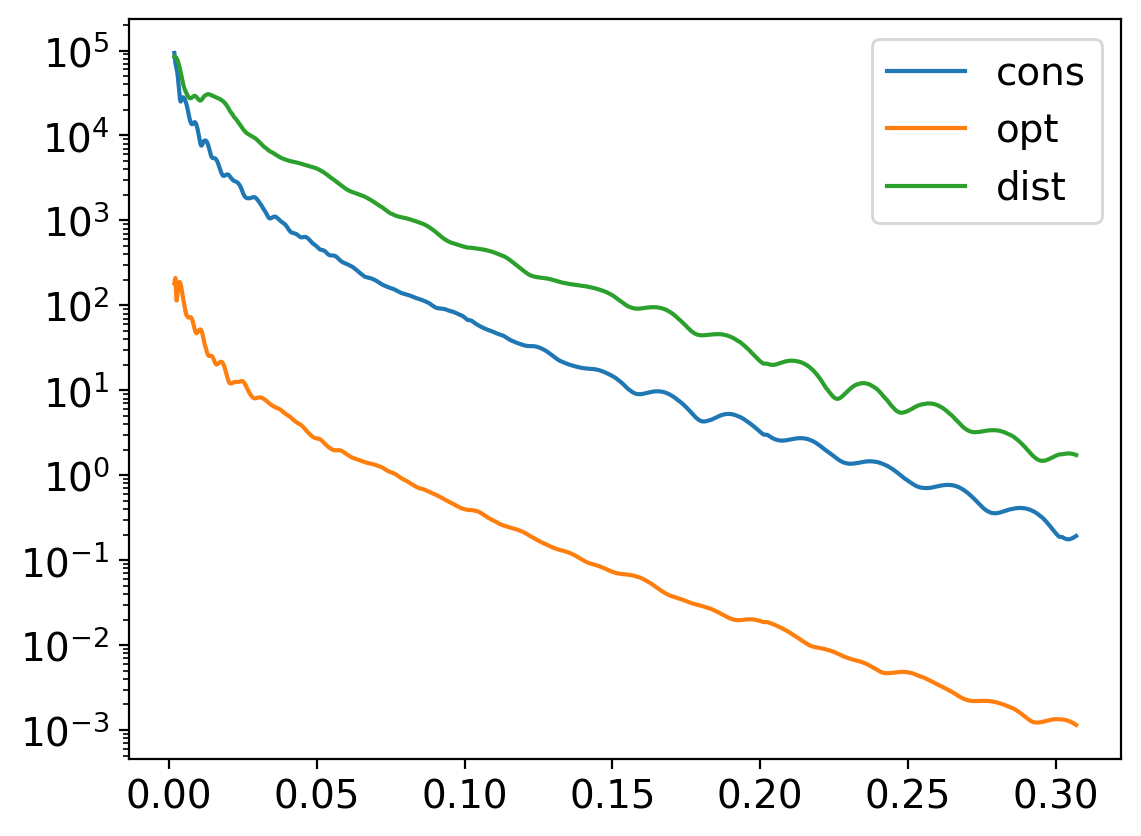

In [12]:
plt.plot(times_s, pri_res, label="cons")
plt.plot(times_s, opt, label="opt")
plt.plot(times_s, dists_s, label="dist")
plt.legend(), plt.yscale("log")


In [13]:
dgapss = []
timess = []
distss = []

for ta_eps in experiment["ta_epss"]:
    output = cyclic(model=twostage_beckmann_model,
                    traffic_assigment_eps_abs=ta_eps, 
                    traffic_assigment_max_iter=experiment["cyclic_ta_iters"], 
                    max_iter=experiment["cyclic_big_iters"], 
                    stop_by_crit=False,
                    solution_flows=flows_e_best,
                    solution_corrs=corrs_best,
                   )
    times_e_cyclic, flows_e_cyclic, d_ij_cyclic, logs, optimal = output
    dgap_cyclic, cons_log_cyclic, time_log_cyclic, dist_flows_log, dist_corrs_log = logs
    
    dgapss.append(dgap_cyclic)    
    timess.append(list(time_log_cyclic))
    distss.append(list((np.array(dist_flows_log) ** 2 + np.array(dist_corrs_log) ** 2) ** 0.5))
    
data["dgapss"] = dgapss
data["timess"] = timess 
data["distss"] = distss 

100%|██████████| 15/15 [00:44<00:00,  2.95s/it]


In [14]:
import json

with open(f"experiments_data/{folder}_salim_vs_cyclic.json", "w") as fp:
    json.dump(experiment, fp)

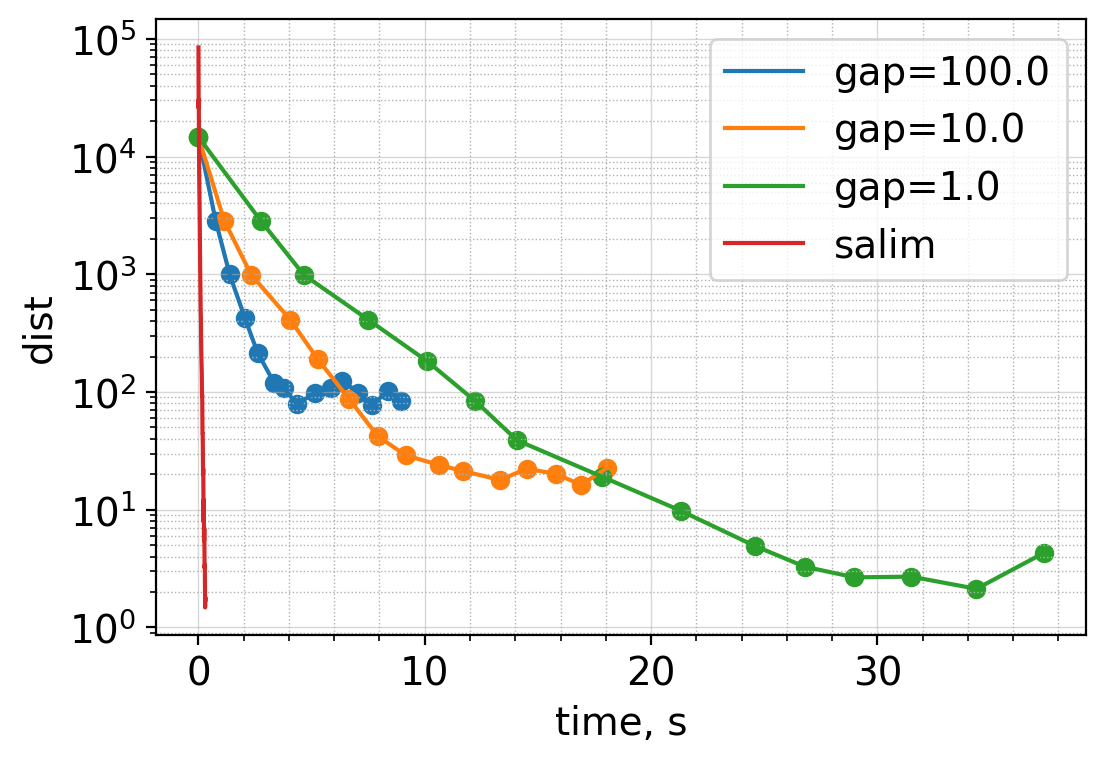

In [15]:
with open(f"experiments_data/{folder}_salim_vs_cyclic.json", "r") as fp:
    experiment = json.load(fp)
data = experiment["data"]
    
plt.figure(figsize=(6,4))

ta_epss = experiment["ta_epss"]
for i in range(len(ta_epss)):
    times, dists = data["timess"][i], data["distss"][i] 
    plt.plot(times, dists, label=f"gap={ta_epss[i]}")
    plt.scatter(times, dists)

plt.plot(data["salim_times"], data["salim_dists"], label="salim")

plt.minorticks_on()
plt.yscale("log")

plt.ylabel("dist")
plt.xlabel("time, s")

minor_locator = LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=12)
plt.gca().yaxis.set_minor_locator(minor_locator)

plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5)
plt.grid(which='minor', linestyle=':', linewidth='0.5', alpha=1) 

plt.legend()

plt.savefig(f"experiments_data/{folder}.pdf", bbox_inches="tight")

In [42]:
salim_with_cheb_kwargs = dict(mu=1e-8, L=100, lam2=1e-4 * l.size, lam1=3.5 * l.size)
# salim_kwargs = experiment["salim_kwargs"]
output = combined_salim_with_cheb(
    admm_oracle,
    **salim_with_cheb_kwargs,
    iters=50,  # =experiment["salim_iters"],
    solution_corrs=corrs_best,
    solution_flows=flows_e_best,
)

100%|██████████| 50/50 [00:38<00:00,  1.30it/s]

5.53771567222926e+28 3.9669647138167075e+28 1.020911496548069e+50
salim 49



/Users/michael/Documents/Transportation/mmo_tm/src/admm_stuff.py:525: RuntimeWarning: Salim reached iter limit
  warnings.warn(f"Salim reached iter limit", category=RuntimeWarning)


(<matplotlib.legend.Legend at 0x293db37d0>, None)

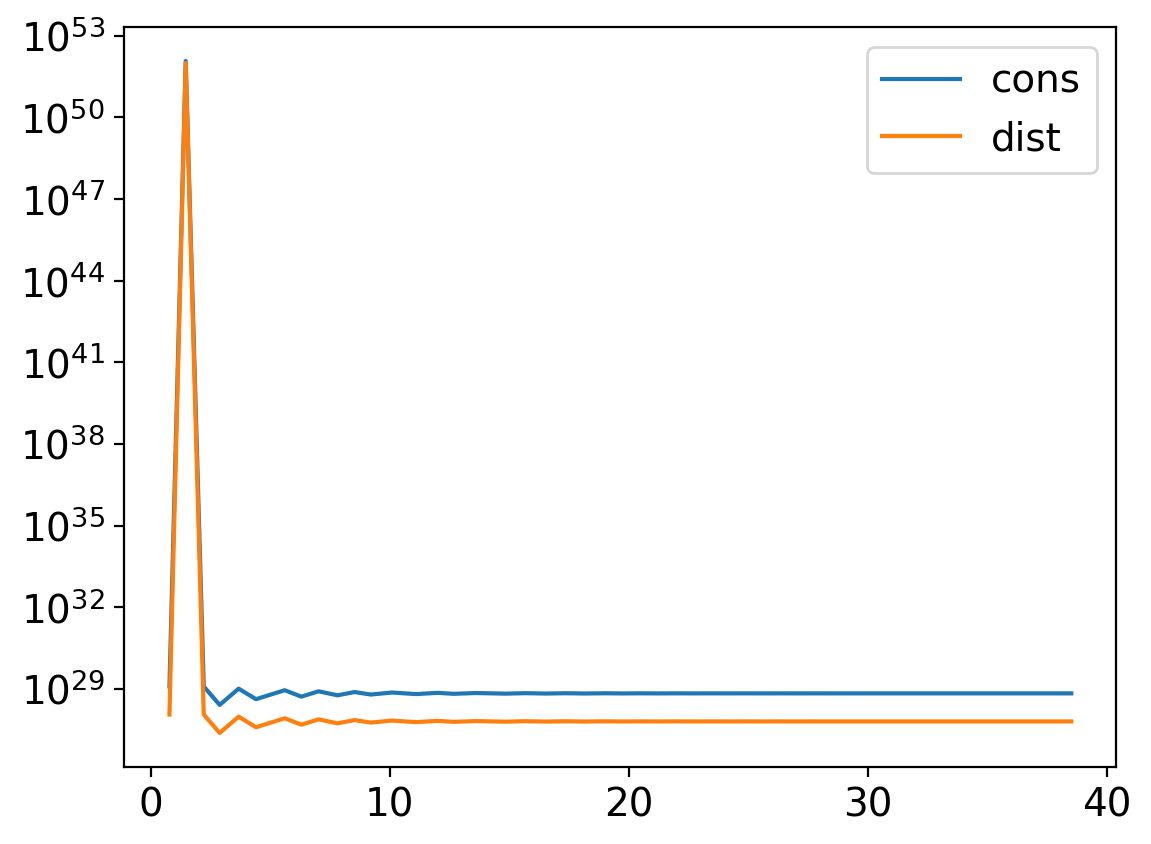

In [44]:
x_corrs, x_flows, u_corrs, u_flows, dist_s_ch, times_s_ch, pri_res_s_ch, opt_s_ch = output
plt.plot(times_s_ch, pri_res_s_ch, label="cons")
# plt.plot(times_s_ch, opt_s_ch, label="opt")
plt.plot(times_s_ch, dist_s_ch, label="dist")
plt.legend(), plt.yscale("log")

In [ ]:
# for Chicago-sketch with
# tm = correspondences.traffic_mat
# tm[tm == 0] = 1
# tm[tm > 10] = tm[tm > 10] * 0.952

comment = "3FW in cyclic"
ta_epss = list(10.0 ** np.arange(3, 2, -1))
# agd_kwargs = dict(eps_abs=1e-4, iters=1000, M0=10)
# salim_kwargs = dict(eps_abs=1e-5, iters=1000, mu=0.01, L=1)
experiment = {"meta": {"network": folder, "description": comment, },
#        "almost_exact" : {"max_iter": 10_000, "ta_eps_abs": 1e-2},
       "almost_exact" : {},
        "cyclic_big_iters": 10,
        "cyclic_ta_iters": 100,
        "ta_epss" : ta_epss,
        "salim_kwargs" : dict(mu=1e-3, L=15,lam2=l.size/10, lam1=4*l.size),
        "salim_iters" : 2000,
        "salim_exact_iters" : 10000,
        "data" : {     
            "dgapss" : None,
            "timess" : None,
            "distss" : None,
            "salim_exact_cons" : None,
            "salim_exact_opt" : None,
            "salim_times" : None,
            "salim_dists" : None,
            },
        }
data = experiment["data"]